In [1]:
import os
import pandas as pd
import uproot
import numpy as np
import pickle
import vector
from sklearn.metrics import roc_curve, auc
import scipy

Import libraries

In [2]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

bdt_axis = hist.axis.Regular(40, 0, 1, name="bdt", label=r"BDT")
xbb_axis = hist.axis.Regular(40, 0.8, 1, name="xbb", label=r"Xbb")
msd_axis = hist.axis.Regular(40, 0, 250, name="msd", label=r"m$_{SD}$ GeV")
mreg_axis = hist.axis.Regular(40, 0, 250, name="mreg", label=r"m$_{reg}$ GeV")

cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [22]:
MAIN_DIR = "../../../"
year = "2018"
path_to_dir_run2 = f"{MAIN_DIR}/../data/skimmer/20211209_regression/"
# path_to_dir_run2 = f"{MAIN_DIR}/../data/skimmer/20210712_regression/"
samples_run2 = {
    "hh4b": [
        "GluGluToHHTo4B_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8_1pb_weighted_Testing_BDTs.root",
        # "GluGluToHHTo4B_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8_1pb_weighted_BDTs.root",
    ],
    "hh4b-kl0": [
        "GluGluToHHTo4B_node_cHHH0_TuneCP5_PSWeights_13TeV-powheg-pythia8_1pb_weighted_BDTs.root",
    ],
    "hh4b-kl2p45": [
        "GluGluToHHTo4B_node_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8_1pb_weighted_BDTs.root",
    ],
    "qcd": [
        "QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
        "QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
        "QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
        "QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
        "QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
        "QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
        "QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted_Testing_BDTs.root",
    ],
    "ttbar": [
        "TTToHadronic_TuneCP5_13TeV-powheg-pythia8-combined_1pb_weighted_Testing_BDTs.root",
        "TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8-combined_1pb_weighted_Testing_BDTs.root",
    ],
}

columns = [
    "run",
    "luminosityBlock",
    "event",
    "fatJet1Pt",
    "fatJet1Eta",
    "fatJet1Phi",
    "fatJet1Mass",
    "fatJet1MassSD",
    "fatJet1MassRegressed",
    "fatJet1PNetXbb",
    "fatJet1PNetQCDb",
    "fatJet1PNetQCDbb",
    "fatJet1PNetQCDothers",
    "fatJet1Tau3OverTau2",
    "fatJet2Pt",
    "fatJet2Eta",
    "fatJet2Phi",
    "fatJet2Mass",
    "fatJet2MassSD",
    "fatJet2PNetXbb",
    "fatJet2PNetQCDb",
    "fatJet2PNetQCDbb",
    "fatJet2PNetQCDothers",
    "fatJet2Tau3OverTau2",
    "fatJet2MassRegressed",
    "fatJet1PtOverMHH",
    "fatJet2PtOverMHH",
    # "fatJet1MassSD_noJMS",
    "ptj2_over_ptj1",
    "hh_pt",
    "hh_eta",
    "hh_mass",
    "met",
    "genHiggs1Pt",
    "genHiggs1Eta",
    "genHiggs1Phi",
    "disc_qcd_and_ttbar_Run2_enhanced_v8p2",
    "xsecWeight",
    "weight",
    "genWeight",
    "triggerEffWeight",
    "puWeight",
]

events_dict = {}
for key, datasets in samples_run2.items():
    dfs = []
    for dset in datasets:
        df = uproot.open(f"{path_to_dir_run2}/{year}/{dset}:Events").arrays(columns, library="pd")
        # df.rename(columns={"luminosityBlock": "lumi"})
        dfs.append(df)
    events_dict[key] = pd.concat(dfs)

Check BDT performance

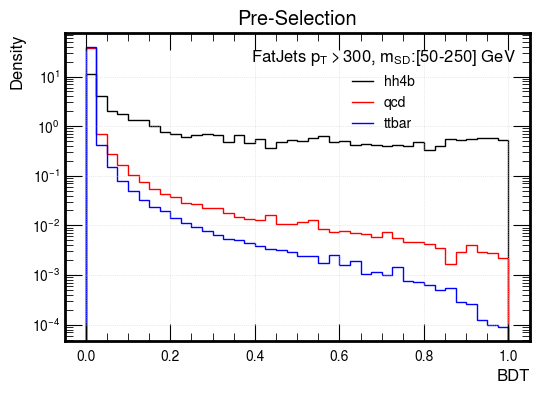

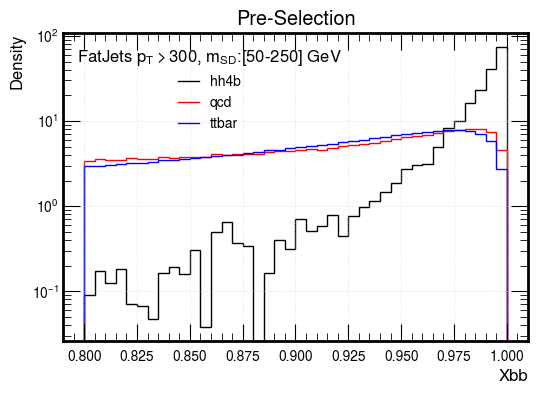

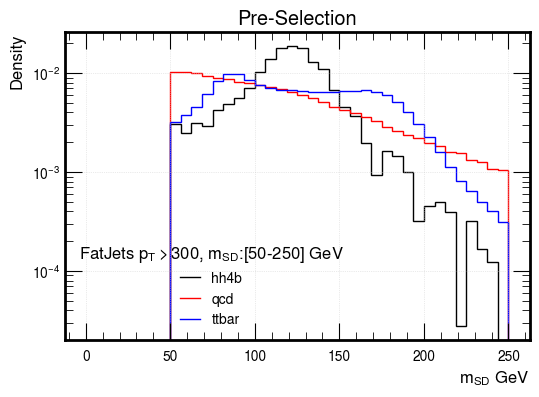

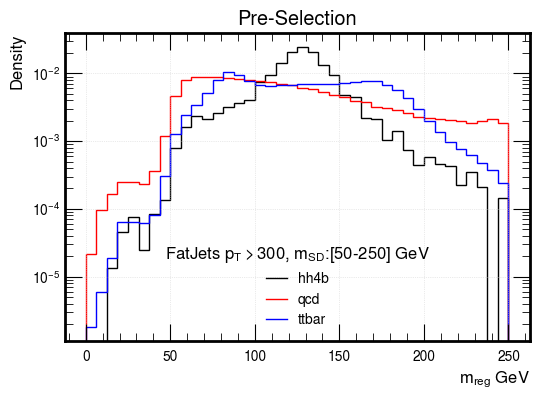

In [36]:
h_bdt = hist.Hist(bdt_axis, cat_axis)
h_xbb0 = hist.Hist(xbb_axis, cat_axis)
h_msd1 = hist.Hist(msd_axis, cat_axis)
h_mreg1 = hist.Hist(mreg_axis, cat_axis)

lumi = 136143

scores = {}
weights = {}
txbb1 = {}
for key in ["hh4b", "qcd", "ttbar"]:
    # pt mask
    # mask = (events_dict[key].fatJet1Pt > 300) & (events_dict[key].fatJet2Pt > 300) & (events_dict[key].fatJet1MassSD > 50) & (events_dict[key].fatJet2MassSD > 50) & (events_dict[key].fatJet1MassSD < 250) & (events_dict[key].fatJet2MassSD < 250)
    mask = (
        (events_dict[key].fatJet1Pt > 300)
        & (events_dict[key].fatJet2Pt > 300)
        & (events_dict[key].fatJet1MassSD > 50)
        & (events_dict[key].fatJet2MassSD > 50)
    )

    scores[key] = events_dict[key][mask]["disc_qcd_and_ttbar_Run2_enhanced_v8p2"].to_numpy()
    weights[key] = (
        events_dict[key][mask]["weight"]
        * events_dict[key][mask]["puWeight"]
        * events_dict[key][mask]["triggerEffWeight"]
        * lumi
    )
    # if "hh4b" not in key:
    #    weights[key] = events_dict[key][mask]["weight"] * events_dict[key][mask]["xsecWeight"] * events_dict[key][mask]["puWeight"] * events_dict[key][mask]["triggerEffWeight"] * lumi
    # else:
    #    weights[key] = events_dict[key][mask]["genWeight"] * events_dict[key][mask]["xsecWeight"] * events_dict[key][mask]["puWeight"] * events_dict[key][mask]["triggerEffWeight"] * lumi
    txbb1[key] = events_dict[key][mask]["fatJet2PNetXbb"]

    # weight = 1
    weight = weights[key]

    h_bdt.fill(
        bdt=events_dict[key][mask]["disc_qcd_and_ttbar_Run2_enhanced_v8p2"].to_numpy(),
        cat=key,
        weight=weight,
    )
    h_xbb0.fill(xbb=events_dict[key][mask]["fatJet1PNetXbb"].to_numpy(), cat=key, weight=weight)
    h_msd1.fill(msd=events_dict[key][mask]["fatJet2MassSD"].to_numpy(), cat=key, weight=weight)
    h_mreg1.fill(
        mreg=events_dict[key][mask]["fatJet2MassRegressed"].to_numpy(), cat=key, weight=weight
    )

colors = {"ttbar": "b", "hh4b": "k", "qcd": "r"}

hists = {
    "bdt": h_bdt,
    "xbb_0": h_xbb0,
    "msd_1": h_msd1,
    "mreg_1": h_mreg1,
}

for hname, hhist in hists.items():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for key in ["hh4b", "qcd", "ttbar"]:
        hep.histplot(
            hhist[{"cat": key}],
            ax=ax,
            label=f"{key}",
            histtype="step",
            linewidth=1,
            color=colors[key],
            density=True,
        )

    ax.set_yscale("log")
    ax.legend(title=r"FatJets $p_T>$300, m$_{SD}$:[50-250] GeV")
    ax.set_ylabel("Density")
    ax.set_title("Pre-Selection")
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True, which="major")

qcd 0.942113336902934
ttbar 0.961265245670373
merged 0.9589992015249473
39654 0.03 0.6946550668630236 0.020830571299937158
13370 0.11 0.5124483461063188 0.006147637164861599
3399 0.43 0.27453342183831175 0.001107231067938455
{0.03: [[0.6946550668630236], [0.020830571299937158]], 0.11: [[0.5124483461063188], [0.006147637164861599]], 0.43: [[0.27453342183831175], [0.001107231067938455]]}


Text(0.2, 5e-05, 'QCD+TT')

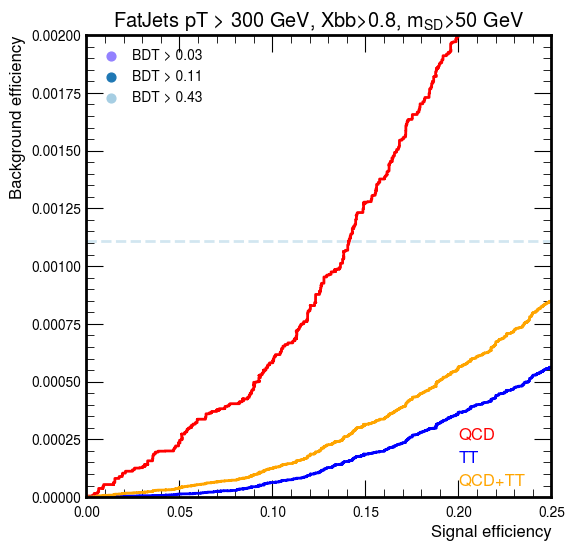

In [37]:
# make roc curve
fpr_dict = {}
auc_dict = {}
tpr_dict = {}
thresholds_dict = {}

for bkg in ["qcd", "ttbar", "merged"]:
    sig_jets_score = scores["hh4b"]
    if bkg == "merged":
        bkg_jets_score = np.concatenate((scores["qcd"], scores["ttbar"]))
        scores_weights = pd.concat([weights["hh4b"], weights["qcd"], weights["ttbar"]], axis=0)
    else:
        bkg_jets_score = scores[bkg]
        scores_weights = pd.concat([weights["hh4b"], weights[bkg]], axis=0)

    scores_roc = np.concatenate((sig_jets_score, bkg_jets_score))
    scores_true = np.concatenate(
        [
            np.ones(len(sig_jets_score)),
            np.zeros(len(bkg_jets_score)),
        ]
    )
    fpr, tpr, thresholds = roc_curve(scores_true, scores_roc, sample_weight=scores_weights)

    sorted_index = np.argsort(fpr)
    fpr_sorted = np.array(fpr)[sorted_index]
    tpr_sorted = np.array(tpr)[sorted_index]
    auc_dict[bkg] = scipy.integrate.trapz(y=tpr_sorted, x=fpr_sorted)
    fpr_dict[bkg] = fpr
    tpr_dict[bkg] = tpr
    thresholds_dict[bkg] = thresholds

plt.figure(figsize=(6, 6))
bkg_colors = {
    "qcd": "r",
    "ttbar": "blue",
    "merged": "orange",
}

for bkg in ["qcd", "ttbar", "merged"]:
    print(bkg, auc_dict[bkg])

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    plot_thresholds = [0.03, 0.11, 0.43]
    th_colours = ["#9381FF", "#1f78b4", "#a6cee3"]

    plt.plot(tpr_dict[bkg], fpr_dict[bkg], linewidth=2, color=bkg_colors[bkg])

    if bkg == "merged":
        pths = {th: [[], []] for th in plot_thresholds}

        for th in plot_thresholds:
            idx = find_nearest(thresholds_dict[bkg], th)
            print(idx, th, tpr_dict[bkg][idx], fpr_dict[bkg][idx])
            pths[th][0].append(tpr_dict[bkg][idx])
            pths[th][1].append(fpr_dict[bkg][idx])

        print(pths)

        for k, th in enumerate(plot_thresholds):
            plt.scatter(
                *pths[th],
                marker="o",
                s=40,
                label=rf"BDT > {th}",
                color=th_colours[k],
                zorder=100,
            )

            plt.vlines(
                x=pths[th][0],
                ymin=0,
                ymax=pths[th][1],
                color=th_colours[k],
                linestyles="dashed",
                alpha=0.5,
            )

            plt.hlines(
                y=pths[th][1],
                xmin=0,
                xmax=pths[th][0],
                color=th_colours[k],
                linestyles="dashed",
                alpha=0.5,
            )

# plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$:[50-250] GeV")
# plt.title(r"FatJets pT > 250 GeV, Xbb>0.8, m$_{SD}$>50 GeV")
plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$>50 GeV")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim([0.0, 0.25])
plt.ylim([0, 0.002])
plt.legend()
plt.text(0.2, 0.00025, "QCD", color=bkg_colors["qcd"])
plt.text(0.2, 0.00015, "TT", color=bkg_colors["ttbar"])
plt.text(0.2, 0.00005, "QCD+TT", color=bkg_colors["merged"])

Adding Xbb cut in the efficiency

qcd 0.6293747333449105
ttbar 0.6287630123347071
merged 0.6288354281104113


Text(0.2, 5e-05, 'QCD+TT')

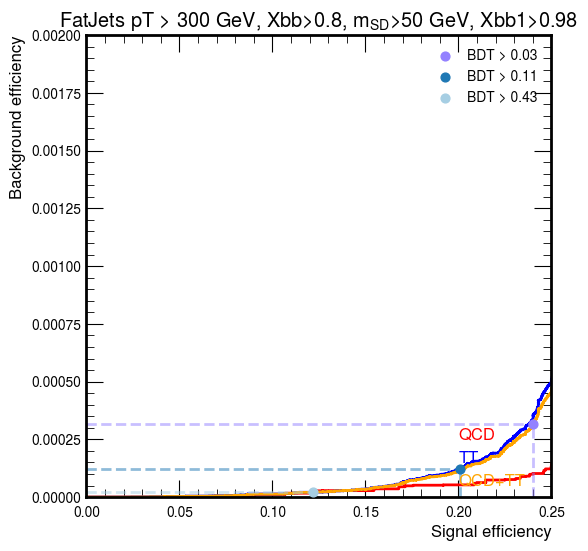

In [39]:
fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}

plt.figure(figsize=(6, 6))
for bkg in ["qcd", "ttbar", "merged"]:
    sig_jets_score = scores["hh4b"]
    if bkg == "merged":
        bkg_jets_score = np.concatenate((scores["qcd"], scores["ttbar"]))
        scores_weights = pd.concat([weights["hh4b"], weights["qcd"], weights["ttbar"]], axis=0)
        scores_txbb = pd.concat([txbb1["hh4b"], txbb1["qcd"], txbb1["ttbar"]], axis=0)
    else:
        bkg_jets_score = scores[bkg]
        scores_weights = pd.concat([weights["hh4b"], weights[bkg]], axis=0)
        scores_txbb = pd.concat([txbb1["hh4b"], txbb1[bkg]], axis=0)

    scores_roc = np.concatenate((sig_jets_score, bkg_jets_score))
    scores_true = np.concatenate(
        [
            np.ones(len(sig_jets_score)),
            np.zeros(len(bkg_jets_score)),
        ]
    )
    scores_roc_thresholded = scores_roc.copy()
    scores_roc_thresholded[scores_txbb < 0.98] = 0

    fpr, tpr, thresholds = roc_curve(
        scores_true, scores_roc_thresholded, sample_weight=scores_weights
    )
    fpr_dict[bkg] = fpr
    tpr_dict[bkg] = tpr
    thresholds_dict[bkg] = thresholds
    sorted_index = np.argsort(fpr)
    fpr_sorted = np.array(fpr)[sorted_index]
    tpr_sorted = np.array(tpr)[sorted_index]
    auc_dict[bkg] = scipy.integrate.trapz(y=tpr_sorted, x=fpr_sorted)

for bkg in ["qcd", "ttbar", "merged"]:
    print(bkg, auc_dict[bkg])

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    plot_thresholds = [0.03, 0.11, 0.43]
    th_colours = ["#9381FF", "#1f78b4", "#a6cee3"]

    pths = {th: [[], []] for th in plot_thresholds}

    plt.plot(tpr_dict[bkg], fpr_dict[bkg], linewidth=2, color=bkg_colors[bkg])

    if bkg != "merged":
        continue

    for th in plot_thresholds:
        idx = find_nearest(thresholds_dict[bkg], th)
        pths[th][0].append(tpr_dict[bkg][idx])
        pths[th][1].append(fpr_dict[bkg][idx])

    for k, th in enumerate(plot_thresholds):
        plt.scatter(
            *pths[th],
            marker="o",
            s=40,
            label=rf"BDT > {th}",
            color=th_colours[k],
            zorder=100,
        )

        plt.vlines(
            x=pths[th][0],
            ymin=0,
            ymax=pths[th][1],
            color=th_colours[k],
            linestyles="dashed",
            alpha=0.5,
        )

        plt.hlines(
            y=pths[th][1],
            xmin=0,
            xmax=pths[th][0],
            color=th_colours[k],
            linestyles="dashed",
            alpha=0.5,
        )

# plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$:[50-250] GeV, Xbb1>0.98")
# plt.title(r"FatJets pT > 250 GeV, Xbb>0.8, m$_{SD}$>50 GeV, Xbb1>0.98")
plt.title(r"FatJets pT > 300 GeV, Xbb>0.8, m$_{SD}$>50 GeV, Xbb1>0.98")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.xlim([0.0, 0.25])
plt.ylim([0, 0.002])
plt.legend()
plt.text(0.2, 0.00025, "QCD", color=bkg_colors["qcd"])
plt.text(0.2, 0.00015, "TT", color=bkg_colors["ttbar"])
plt.text(0.2, 0.00005, "QCD+TT", color=bkg_colors["merged"])

Obtain signal and background efficiency manually

In [20]:
yields = {}
yields_bdt043 = {}
yields_bdt043_xbb098 = {}


for key in ["hh4b", "qcd", "ttbar"]:
    # pt mask
    mask = (events_dict[key].fatJet1Pt > 300) & (events_dict[key].fatJet2Pt > 300)

    # bdt043
    mask = mask & (events_dict[key].disc_qcd_and_ttbar_Run2_enhanced_v8p2 > 0.43)

    # xbb 098
    mask_xbb = mask & (events_dict[key].fatJet2PNetXbb > 0.98)

    lumi = 13700

    if "hh4b" not in key:
        yields[key] = np.sum(lumi * events_dict[key]["weight"] * events_dict[key]["xsecWeight"])
        yields_bdt043[key] = np.sum(
            lumi * events_dict[key][mask]["weight"] * events_dict[key][mask]["xsecWeight"]
        )
        yields_bdt043_xbb098[key] = np.sum(
            lumi * events_dict[key][mask_xbb]["weight"] * events_dict[key][mask_xbb]["xsecWeight"]
        )
    else:
        yields[key] = np.sum(lumi * events_dict[key]["genWeight"] * events_dict[key]["xsecWeight"])
        yields_bdt043[key] = np.sum(
            lumi * events_dict[key][mask]["genWeight"] * events_dict[key][mask]["xsecWeight"]
        )
        yields_bdt043_xbb098[key] = np.sum(
            lumi
            * events_dict[key][mask_xbb]["genWeight"]
            * events_dict[key][mask_xbb]["xsecWeight"]
        )

sig_eff_bdt043 = yields_bdt043["hh4b"] / yields["hh4b"]
bkg_eff_bdt043 = (yields_bdt043["qcd"] + yields_bdt043["ttbar"]) / (yields["qcd"] + yields["ttbar"])

sig_eff_bdt043_xbb098 = yields_bdt043_xbb098["hh4b"] / yields["hh4b"]
bkg_eff_bdt043_xbb098 = (yields_bdt043_xbb098["qcd"] + yields_bdt043_xbb098["ttbar"]) / (
    yields["qcd"] + yields["ttbar"]
)

print(yields)
print(
    yields_bdt043,
    sig_eff_bdt043,
    bkg_eff_bdt043,
    2 * yields_bdt043["hh4b"] / np.sqrt(yields_bdt043["qcd"] + yields_bdt043["ttbar"]),
)
print(
    yields_bdt043_xbb098,
    sig_eff_bdt043_xbb098,
    bkg_eff_bdt043_xbb098,
    2
    * yields_bdt043_xbb098["hh4b"]
    / np.sqrt(yields_bdt043_xbb098["qcd"] + yields_bdt043_xbb098["ttbar"]),
)

{'hh4b': 0.043524317, 'qcd': 1177746.5, 'ttbar': 257.8379}
{'hh4b': 0.0070833485, 'qcd': 2150.963, 'ttbar': 0.12920803} 0.16274463 0.0018260475 0.00030544927520622083
{'hh4b': 0.0028379373, 'qcd': 16.505917, 'ttbar': 0.0035847733} 0.06520349 1.4014804e-05 0.0013969016147400272


In [41]:
yields = {}
yields_bdt043 = {}
yields_bdt043_xbb098 = {}


for key in ["hh4b", "qcd", "ttbar"]:
    # pt mask
    # mask = (events_dict[key].fatJet1Pt > 250) & (events_dict[key].fatJet2Pt > 250)
    mask = (events_dict[key].fatJet1Pt > 300) & (events_dict[key].fatJet2Pt > 300)
    # bdt043
    mask = mask & (events_dict[key].disc_qcd_and_ttbar_Run2_enhanced_v8p2 > 0.43)

    # xbb 098
    mask_xbb = mask & (events_dict[key].fatJet2PNetXbb > 0.98)

    lumi = 13700

    weight = events_dict[key]["puWeight"] * events_dict[key]["triggerEffWeight"] * lumi
    weight_mask = (
        events_dict[key][mask]["puWeight"] * events_dict[key][mask]["triggerEffWeight"] * lumi
    )
    weight_mask_xbb = (
        events_dict[key][mask_xbb]["puWeight"]
        * events_dict[key][mask_xbb]["triggerEffWeight"]
        * lumi
    )

    # if "hh4b" not in key:
    yields[key] = np.sum(weight * events_dict[key]["weight"])
    yields_bdt043[key] = np.sum(weight_mask * events_dict[key][mask]["weight"])
    yields_bdt043_xbb098[key] = np.sum(weight_mask_xbb * events_dict[key][mask_xbb]["weight"])
    # else:
    #    yields[key] = np.sum(weight * events_dict[key]["genWeight"])
    #    yields_bdt043[key] = np.sum(weight_mask * events_dict[key]["genWeight"])
    #    yields_bdt043_xbb098[key] = np.sum(weight_mask_xbb * events_dict[key]["genWeight"])

sig_eff_bdt043 = yields_bdt043["hh4b"] / yields["hh4b"]
bkg_eff_bdt043 = (yields_bdt043["qcd"] + yields_bdt043["ttbar"]) / (yields["qcd"] + yields["ttbar"])

sig_eff_bdt043_xbb098 = yields_bdt043_xbb098["hh4b"] / yields["hh4b"]
bkg_eff_bdt043_xbb098 = (yields_bdt043_xbb098["qcd"] + yields_bdt043_xbb098["ttbar"]) / (
    yields["qcd"] + yields["ttbar"]
)

print(yields)
print(
    yields_bdt043,
    sig_eff_bdt043,
    bkg_eff_bdt043,
    2 * yields_bdt043["hh4b"] / np.sqrt(yields_bdt043["qcd"] + yields_bdt043["ttbar"]),
)
print(
    yields_bdt043_xbb098,
    sig_eff_bdt043_xbb098,
    bkg_eff_bdt043_xbb098,
    2
    * yields_bdt043_xbb098["hh4b"]
    / np.sqrt(yields_bdt043_xbb098["qcd"] + yields_bdt043_xbb098["ttbar"]),
),

{'hh4b': 126408744.0, 'qcd': 6235186700.0, 'ttbar': 36237844000.0}
{'hh4b': 27680438.0, 'qcd': 16906180.0, 'ttbar': 22777618.0} 0.21897566 0.0009343294 8788.12720735871
{'hh4b': 11508707.0, 'qcd': 75749.99, 'ttbar': 606522.44} 0.0910436 1.6063663e-05 27866.190712597636


(None,)

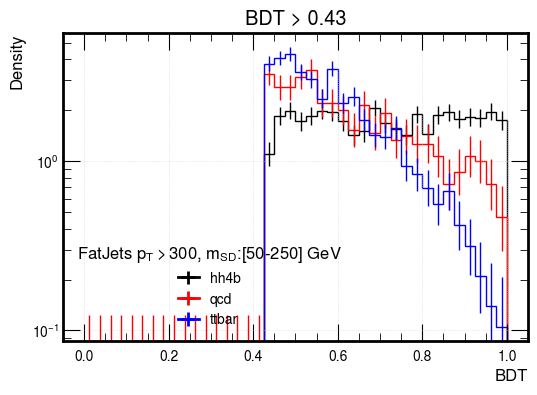

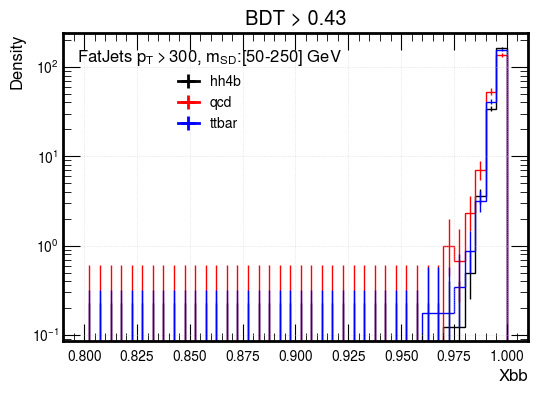

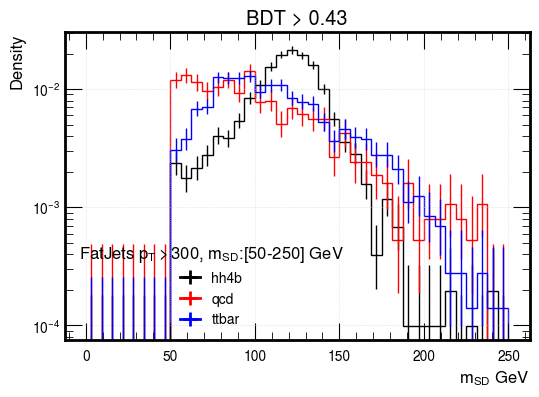

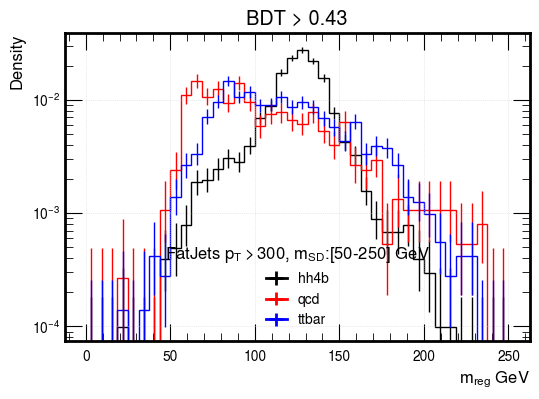

In [ ]:
h_bdt = hist.Hist(bdt_axis, cat_axis)
h_xbb0 = hist.Hist(xbb_axis, cat_axis)
h_msd1 = hist.Hist(msd_axis, cat_axis)
h_mreg1 = hist.Hist(mreg_axis, cat_axis)

scores = {}
weights = {}
txbb1 = {}
for key in ["hh4b", "qcd", "ttbar"]:
    # pt mask
    mask = (
        (events_dict[key].fatJet1Pt > 300)
        & (events_dict[key].fatJet2Pt > 300)
        & (events_dict[key].fatJet1MassSD > 50)
        & (events_dict[key].fatJet2MassSD > 50)
        & (events_dict[key].fatJet1MassSD < 250)
        & (events_dict[key].fatJet2MassSD < 250)
        & (events_dict[key]["disc_qcd_and_ttbar_Run2_enhanced_v8p2"] > 0.43)
    )

    h_bdt.fill(
        bdt=events_dict[key][mask]["disc_qcd_and_ttbar_Run2_enhanced_v8p2"].to_numpy(), cat=key
    )
    h_xbb0.fill(xbb=events_dict[key][mask]["fatJet1PNetXbb"].to_numpy(), cat=key)
    h_msd1.fill(msd=events_dict[key][mask]["fatJet2MassSD"].to_numpy(), cat=key)
    h_mreg1.fill(mreg=events_dict[key][mask]["fatJet2MassRegressed"].to_numpy(), cat=key)

    scores[key] = events_dict[key][mask]["disc_qcd_and_ttbar_Run2_enhanced_v8p2"].to_numpy()
    if "hh4b" not in key:
        weights[key] = events_dict[key][mask]["weight"] * events_dict[key][mask]["xsecWeight"]
    else:
        weights[key] = events_dict[key][mask]["genWeight"] * events_dict[key][mask]["xsecWeight"]
    txbb1[key] = events_dict[key][mask]["fatJet2PNetXbb"]

colors = {"ttbar": "b", "hh4b": "k", "qcd": "r"}

hists = {
    "bdt": h_bdt,
    "xbb_0": h_xbb0,
    "msd_1": h_msd1,
    "mreg_1": h_mreg1,
}

for hname, hhist in hists.items():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for key in ["hh4b", "qcd", "ttbar"]:
        hep.histplot(
            hhist[{"cat": key}],
            ax=ax,
            label=f"{key}",
            histtype="step",
            linewidth=1,
            color=colors[key],
            density=True,
        )

    ax.set_yscale("log")
    ax.legend(title=r"FatJets $p_T>$300, m$_{SD}$:[50-250] GeV")
    ax.set_ylabel("Density")
    ax.set_title("BDT > 0.43")
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True, which="major")